<a href="https://colab.research.google.com/github/madelinehooo/Week3-ClassicML/blob/assignment/Week_3_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<center><h1> Introduction to Audio Classification with Machine Learning Models </h1></center>



### Purpose
This notebook serves as an introduction to working with audio data for classification problems; it is meant as a learning resource rather than a demonstration of the state-of-the-art. The techniques mentioned in this notebook apply not only to classification problems, but to regression problems and problems dealing with other types of input data as well. I provide an introduction to a few key machine learning models and the logic in choosing their hyperparameters. These objectives are framed by the task of recognizing emotion from snippets of speech audio.

 Training data should be used strictly for training a model, validation data strictly for tuning a model, and test data strictly to evaluate a model once it is tuned - a model should never be tuned to perform better on test data.





Classic machine learning models such as Support Vector Machines (SVM), k Nearest Neighbours (kNN), and Random Forests have distinct advantages to deep neural networks in many tasks.

<!--TABLE OF CONTENTS-->


# Table of Contents
  - [Intro: Speech Emotion Recognition on the RAVDESS dataset](#Intro:-Speech-Emotion-Recognition-on-the-RAVDESS-dataset)
  - [Machine Learning Process Overview](#Machine-Learning-Process-Overview)
  - [Feature Extraction](#Feature-Extraction)
    - [Load the Dataset and Compute Features](#Load-the-Dataset-and-Compute-Features)
    - [Feature Scaling](#Feature-Scaling)
  - [Classical Machine Learning Models](#Classical-Machine-Learning-Models)
    - [Training: The 80/20 Split and Validation](#Training:-The-80/20-Split-and-Validation)
    - [Comparing Models](#Comparing-Models)
    - [The Support Vector Machine Classifier](#The-Support-Vector-Machine-Classifier)
    - [k Nearest Neighbours](#k-Nearest-Neighbours)
    - [Random Forests](#Random-Forests)



## Intro: Speech Emotion Recognition on the RAVDESS dataset
In this notebook we explore the most common machine learning models, specifically those available off the shelf in scikit-learn.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
[Details of the RAVDESS dataset](https://smartlaboratory.org/ravdess/) <br>
[Download the dataset used in this notebook](https://zenodo.org/record/1188976) <br> Scroll half-way down the page and find "Audio_Speech_Actors_01-24"<br>

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with
a variety of emotions and intensity. We get 1440 speech files (24 actors * 60 recordings per actor). Each audio sample has been rated  by a human 10 times for emotional quality.

## Machine Learning Process Overview
1. Feature Engineering: Choose and define the properties which our model will use to evaluate the audio files. <br>
2. Feature Extraction: Compute the features for each audio file and build a feature matrix representing all audio files. <br>
3. Model exploration: Test candidate models that make sense for the properies of the dataset
4. Training the MLP Classifier model: Choose and optimize the properties of our model on validation data - hyperparameters and architechture.  <br>
5. Evaluate our model's performance: Evaluate our model's accuracy on validation data and score it against test data which it has never seen in training.<br>
6. Explore options for improving our model: Is our dataset the right size? Is our model too complex or too simple? <br>


In [122]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

## Feature Extraction
We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction.
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC.
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well

In [123]:


def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0) #because chromagram produces 12 features, so the array is size 12
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.

In [124]:
def preprocess_waveform(waveform):
    # If the waveform has 2 channels (stereo), convert it to mono
    if len(waveform.shape) > 1:
        waveform = librosa.to_mono(waveform)
    return waveform

In [125]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # make sure the file is mono channel audio
        waveform = preprocess_waveform(waveform)
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])

        # Check the shape of chromagram
        if chromagram.ndim > 1 and chromagram.shape[1] > 1:
            #print(f"Returning zero vector for chromagram size: {file} (shape: {chromagram.shape})")
            chromagram = np.zeros((12,))  # Return a zero vector of size (12,)

        # Check the shape of mel spectrogram
        if melspectrogram.ndim > 1 and melspectrogram.shape[1] > 1:
            #print(f"Returning zero vector for mel spectrogram size: {file} (shape: {melspectrogram.shape})")
            melspectrogram = np.zeros((128,))  # Return a zero vector of size (128,)

        # Check the shape of MFCC coefficients
        if mfc_coefficients.ndim > 1 and mfc_coefficients.shape[1] > 1:
            #print(f"Returning zero vector for MFCC size: {file} (shape: {mfc_coefficients.shape})")
            mfc_coefficients = np.zeros((40,))  # Return a zero vector of size (40,)

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

### Load the Dataset and Compute Features
We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-".
Most of the numbers describe metadata about the audio samples such as their format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.

The third and fourth numbers pertain to the emotional quality of each sample. The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:

In [126]:
#Emotions in the RAVDESS dataset
emotions_dict ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Finally, let's load our entire dataset and compute the features of each audio file:

In [130]:
#Tutorial
# import os, glob

# def load_data():
#     X,y=[],[]
#     count = 0
#     for file in glob.glob("RAVDESS/*/*.wav"):
#         file_name=os.path.basename(file)
#         emotion=emotions_dict[file_name.split("-")[2]]
#         features = get_features(file)
#         X.append(features)
#         y.append(emotion)
#         count += 1
#         # '\r' + end='' results in printing over same line
#         print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
#     # Return arrays to plug into sklearn's cross-validation algorithms
#     return np.array(X), np.array(y)

In [131]:
#My data
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("Audio Data/*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_dict[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{10} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.

In [132]:
features, emotions = load_data()

 Processed 8/10 audio samples 

Let's see what the features we extracted look like, **also for saving both the features matrix as well as emotions array, we need to convert them to pandas dataframe.**

In [133]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 8
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.692078,0.662306,0.615321,0.604491,0.626875,0.633277,0.669701,0.706609,0.780290,0.801787,...,-1.881757,0.043088,0.579227,0.227303,-0.803910,0.946197,0.549679,1.121082,3.698055,2.253160
1,0.712374,0.659345,0.603158,0.607966,0.604705,0.604513,0.609466,0.620567,0.709549,0.736907,...,0.348475,2.054709,2.774870,1.496095,0.573735,4.057434,2.627321,3.368062,4.686047,1.684066
2,0.742169,0.732724,0.654809,0.619032,0.598200,0.578263,0.581996,0.587977,0.638148,0.672355,...,2.181135,4.863778,2.328446,1.677886,1.524842,1.511981,2.112899,0.337700,2.559954,-0.753613
3,0.605811,0.529507,0.481609,0.510066,0.558733,0.624502,0.687098,0.701264,0.731871,0.725376,...,-4.801785,2.408797,2.437171,0.965133,1.851146,2.614240,3.446011,3.202496,5.235974,0.816371
4,0.656950,0.653488,0.637538,0.613122,0.605922,0.627499,0.617887,0.597108,0.609731,0.622461,...,0.747061,2.326679,0.615701,1.996628,-0.344382,0.718175,3.122183,0.555035,3.722613,0.070168
5,0.814509,0.715103,0.631952,0.581045,0.587668,0.596967,0.625317,0.617955,0.649813,0.712264,...,-0.522831,4.029278,4.168990,2.105710,5.992561,3.510252,4.537448,2.791991,2.633150,1.064741
6,0.713009,0.722858,0.695343,0.651812,0.649580,0.634555,0.639391,0.637519,0.656285,0.687857,...,-1.650295,1.497661,-1.112292,-0.633841,-0.560715,-2.276905,-0.453305,-1.170852,-0.638217,-2.423357
7,0.737934,0.703345,0.647583,0.635451,0.619606,0.623714,0.649939,0.662076,0.697972,0.710959,...,-0.104570,3.406073,1.847111,0.660000,2.080033,1.312851,0.202078,1.775864,1.698233,-0.506996


We have a matrix of dim 1435 x 180. Looks good - 1435 audio samples, one per row, with a series of
180 numerical features for each sample.

**Each of the 1435 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**

Now we will save our features matrix and emotions array in excel file we dont have to compute them everytime we run the notebook, we can just load them from the excel file whenever required. Make sure to change the path to according to your drive.

In [134]:
#Tutorial
# features_df.to_csv('featuresRavdess.csv')
# emotions_df.to_csv('emotionsRavdess.csv')


In [135]:
#My Data
features_df.to_csv('featuresRavdess_me.csv')
emotions_df.to_csv('emotionsRavdess_me.csv')

## Load pre-saved Dataset

Once saved you only need to load them later by running the cell below, and **skip every cell above** except for the one in which we import libraries.

In [136]:
#Tutorial
features=pd.read_csv('featuresRavdess.csv',index_col=0)
emotions=pd.read_csv('emotionsRavdess.csv',index_col=0)

In [137]:
#My Data
features_me=pd.read_csv('featuresRavdess_me.csv',index_col=0)
emotions_me=pd.read_csv('emotionsRavdess_me.csv',index_col=0)

let's see if they have been loaded correctly!

In [138]:
#Tutorial
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.762871,0.786686,0.769217,0.768762,0.773605,0.766615,0.770437,0.764894,0.780340,0.761150,...,0.457082,-1.399110,-2.926856,0.013957,-0.490734,-0.570905,0.040399,-1.207218,-1.594982,-1.436487
1,0.747417,0.781693,0.774763,0.755513,0.770826,0.783455,0.754270,0.748580,0.766922,0.768814,...,0.275460,-2.521470,-2.987673,0.409735,-0.484184,-1.398391,0.255203,-0.984978,-2.093061,-1.040791
2,0.767132,0.788347,0.785653,0.786579,0.777644,0.755638,0.761176,0.752333,0.774452,0.743741,...,-0.002119,-0.909152,-3.045956,-0.373294,-0.849145,-0.922105,-0.170320,-1.144422,-1.725612,-1.450560
3,0.765556,0.760809,0.754814,0.773621,0.797597,0.785697,0.754200,0.761343,0.742356,0.725235,...,-0.403806,-1.329651,-2.513405,-0.190276,-0.645949,-0.553919,0.459299,-1.580085,-1.647682,-1.509511
4,0.706621,0.751378,0.765777,0.754598,0.759112,0.770332,0.755594,0.741855,0.750050,0.755684,...,0.206463,-2.188582,-2.835501,0.463746,-1.019167,-1.411441,0.350433,-1.519892,-1.250112,-0.613852


In [139]:
#My Data
features_me.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.692078,0.662306,0.615321,0.604491,0.626875,0.633277,0.669701,0.706609,0.780290,0.801787,...,-1.881757,0.043088,0.579227,0.227303,-0.803910,0.946197,0.549679,1.121082,3.698055,2.253160
1,0.712374,0.659345,0.603158,0.607966,0.604705,0.604513,0.609466,0.620567,0.709549,0.736907,...,0.348475,2.054709,2.774870,1.496095,0.573735,4.057434,2.627321,3.368062,4.686047,1.684066
2,0.742169,0.732724,0.654809,0.619032,0.598200,0.578263,0.581996,0.587977,0.638148,0.672355,...,2.181135,4.863778,2.328446,1.677886,1.524842,1.511982,2.112899,0.337700,2.559954,-0.753613
3,0.605811,0.529507,0.481609,0.510066,0.558733,0.624502,0.687098,0.701264,0.731871,0.725376,...,-4.801786,2.408797,2.437171,0.965133,1.851146,2.614240,3.446011,3.202496,5.235974,0.816371
4,0.656950,0.653488,0.637538,0.613122,0.605922,0.627499,0.617887,0.597108,0.609731,0.622461,...,0.747061,2.326679,0.615701,1.996628,-0.344382,0.718175,3.122183,0.555035,3.722613,0.070168


Let's see the class balance of our dataset:

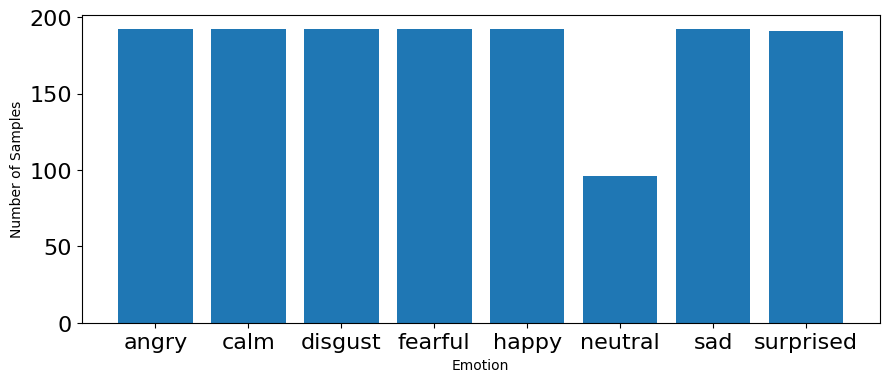

In [140]:
#Tutorial

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

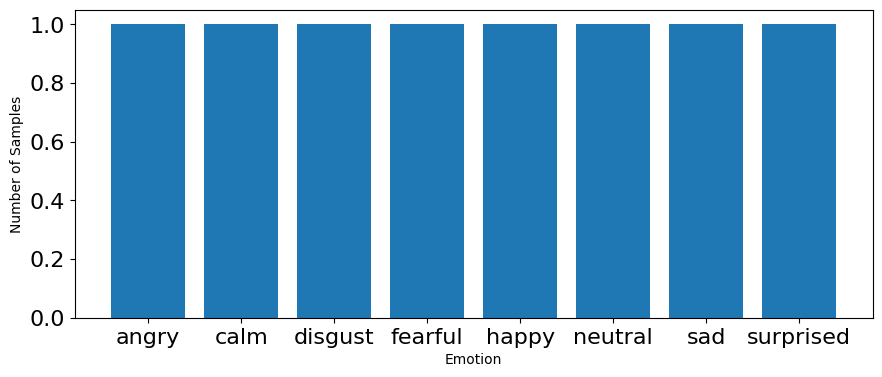

In [141]:
#My Data

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions_me, return_counts=True)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

**Great, the classes appear to be balanced. That makes the task easier.** All emotions _except_ the neutral class have a "strong" intensity so there are half as many neutral samples. That might have an impact.

### Feature Scaling
To properly train most machine learning models on _most_ datasets, we first need to scale our features. **This is crucial for models which compute distances between data, and especially critical for DNNs**: If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important. However, **differences in the variance of unscaled features belonging to different and unknown distributions is an inappropriate measure of importance.** Let's check our features' properties:

In [146]:
#Tutorial
features.describe()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
count,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,...,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000,1439.000000
mean,0.650085,0.644362,0.647661,0.655540,0.672123,0.682313,0.685750,0.676902,0.680570,0.672386,...,-0.331587,0.340400,-0.261223,0.643757,0.542990,0.488295,0.564299,0.693862,0.417006,0.893276
std,0.079958,0.089343,0.093374,0.094697,0.095863,0.091064,0.086202,0.083203,0.082440,0.081272,...,2.225222,2.327544,2.184184,2.085400,2.016637,1.987201,1.935450,1.896175,1.959625,1.999345
min,0.378328,0.340238,0.310377,0.331314,0.390025,0.378070,0.350047,0.363718,0.406125,0.414586,...,-5.994778,-4.969791,-5.206000,-4.321074,-4.948631,-6.151189,-5.380692,-4.377184,-4.573127,-4.713404
25%,0.598379,0.582815,0.581055,0.586055,0.600526,0.617650,0.624102,0.621030,0.623838,0.620019,...,-1.762381,-1.172788,-1.688962,-0.762177,-0.799072,-0.800608,-0.780440,-0.573444,-0.956096,-0.485928
50%,0.654876,0.649669,0.655052,0.668835,0.691003,0.702265,0.703367,0.691409,0.695257,0.687079,...,-0.563176,0.019998,-0.452503,0.385209,0.246903,0.217135,0.377462,0.542140,0.145143,0.637917
75%,0.706563,0.713002,0.719653,0.728089,0.746028,0.749260,0.748559,0.738186,0.742406,0.731090,...,0.760126,1.519243,0.935825,1.757782,1.664413,1.731556,1.652921,1.791810,1.585066,2.039096
max,0.999220,1.000000,0.993107,0.993467,0.987711,0.982193,0.977960,0.978808,0.985013,0.988497,...,12.655916,14.277499,10.516112,11.420576,9.299726,8.715325,10.268682,9.382308,9.480828,10.302836


In [148]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.482,     max = 0.841,     mean = 0.661,     deviation = 0.065

128 Mel Spectrogram features:     min = 0.001,     max = 25.897,     mean = 0.562,     deviation = 2.077

40 MFCC features:                 min = -454.077,    max = 132.751,    mean = -6.100,    deviation = 70.940


**There's an obvious imbalance in the variance our features; Our features indeed belong to very different distributions:** our MFC coefficients' deviation is greater than the other features by orders of magnitude. That does not mean MFC coefficients are the most important feature, but rather it is a property of the way they are computed.  We will certainly need to scale this feature set.

We have the choice of sklearn's StandardScaler and MinMaxScaler. Standard scaling subtracts the mean of each feature and divides it by the standard deviation of that feature, producing features with mean at zero and unit variance - that is, a variance and standard deviation of 1. Min-Max scaling transforms each feature to be within a bounded interval that we specify.

In practice, **MinMax scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while **standard scaling is perhaps more practical for features with unknown distributions** because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers.

We'll create MinMax scaled features as well so we can give them a try later on to confirm that standard scaling is better in the absence of knowledge on the appropriate distribution for a dataset's features.

In [149]:
#Tutorial

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler() # subtracts-1 to 1, mean is 0
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler() #
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [150]:
#My data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled_me = features_me
features_scaled_me = scaler.fit_transform(features_scaled_me)

scaler = MinMaxScaler() #
# keep our unscaled features just in case we need to process them alternatively
features_minmax_me = features_me
features_minmax_me = scaler.fit_transform(features_minmax_me)

Make sure our features are properly scaled:

In [151]:
#Tutorial
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -3.896,     max = 4.368,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.474,     max = 36.531,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -4.803,    max = 6.238,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.472,     deviation = 0.145

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.015,     deviation = 0.061

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.412,    deviation = 0.169


In [153]:
#My data
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled_me)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax_me)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -2.374,     max = 2.253,     mean = -0.000,     deviation = 1.005

128 Mel Spectrogram features:     min = -2.019,     max = 2.641,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -2.319,    max = 2.278,    mean = 0.000,    deviation = 1.002


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.541,     deviation = 0.314

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.339,     deviation = 0.354

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.521,    deviation = 0.331


Perfect. Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.

## Classical Machine Learning Models


Classical machine learning models encompass a broad range of algorithms that have been foundational to the field's development and are still widely used for various predictive tasks. These models can be broadly categorized into supervised and unsupervised learning methods, each suited for different kinds of data and objectives.

We will be looking into few popular Machine Learning Algorithms such as Support Vector Machine(SVM), K-Nearest Neighbors and Random Forest Classifier. There are many other classical models with their own strengths and weaknesses, and the choice of model depends on the specific requirements of the task, including the nature of the data, the complexity of the problem, and the computational efficiency required. Despite the rise of deep learning, classical machine learning models remain vital tools in a data scientist's arsenal due to their efficiency, interpretability, and strong performance in many scenarios.

The use of classic machine learning method is due to the small size of our dataset; Some of the most robust models such as Support vector (machine) classifiers **(SVC) and k-Nearest-Neighbour classifiers (kNN) are particularly suited to smaller datasets and fall apart with huge datasets.**


### Training: The 80/20 Split and Validation
In order to compare models, we'll have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.
 <img src="https://github.com/IAT-ExploringAI-2024/Week3-Machine_Learning/blob/main/images/Capture2.PNG?raw=true" width="800">

More accurately, the proper modality for training and scoring a model is to
1. Fit/train our model on a _training_ set,
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set.
4. Repeat from 2. **Do not tune the model to score well on the test set**. Only evaluate on test-set once.

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test.For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data. We'll skip validation for now.

 <img src="https://github.com/IAT-ExploringAI-2024/Week3-ClassicML/blob/main/images/traintestsplit.PNG?raw=true" width="800">

Define unscaled and scaled training and test sets:

In [154]:
#Tutorial

from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split( #training features, testing features, target values/labels for the train set, target of the test
    features,
    emotions,
    test_size=0.2,
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=42
)

In [155]:
#My Data

from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train_me, X_test_me, y_train_me, y_test_me =train_test_split( #training features, testing features, target values/labels for the train set, target of the test
    features_me,
    emotions_me,
    test_size=0.2,
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled_me, X_test_scaled_me, _, _ = train_test_split(
    features_scaled_me,
    emotions_me,
    test_size=0.2,
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax_me, X_test_minmax_me, _, _ = train_test_split(
    features_minmax_me,
    emotions_me,
    test_size=0.2,
    random_state=42
)

### Comparing Models
We'll try each off-the-shelf machine learning model from sklearn and pick a few to explore, since these models will train near instantly on this dataset.

**Compare Classifier Performance with Scaled Features**



In [158]:
#My Data - Unscaled
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores_unscaled = []
for model in classification_models:
    model.fit(X_train, y_train) #model trains one data each time
    score = model.score(X_test, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores_unscaled.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_unscaled_df = pd.DataFrame(scores_unscaled,columns=['Classifier','Unscaled Score'])
scores_unscaled_df.sort_values(by='Unscaled Score',axis=0,ascending=False)

,Classifier,Unscaled Score
4,RandomForestClassifier,56.94%
0,KNeighborsClassifier,51.39%
1,SVC,47.57%
3,DecisionTreeClassifier,35.42%
6,GaussianNB,33.33%
5,AdaBoostClassifier,30.21%
2,SVC RBF kernel,29.86%
7,QuadraticDiscriminantAnalysis,22.57%


In [160]:
#My Data - Scaled
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores_scaled = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores_scaled.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_scaled_df = pd.DataFrame(scores_scaled,columns=['Classifier','Scaled Score'])
scores_scaled_df.sort_values(by='Scaled Score',axis=0,ascending=False)

,Classifier,Scaled Score
4,RandomForestClassifier,61.81%
0,KNeighborsClassifier,55.90%
1,SVC,50.35%
2,SVC RBF kernel,50.35%
3,DecisionTreeClassifier,36.11%
5,AdaBoostClassifier,30.21%
6,GaussianNB,30.21%
7,QuadraticDiscriminantAnalysis,21.53%


In [163]:
#My Data - Min/Max
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores_minmax = []
for model in classification_models:
    model.fit(X_train_minmax, y_train) #model trains one data each time
    score = model.score(X_test_minmax, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores_minmax.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_minmax_df = pd.DataFrame(scores_minmax,columns=['Classifier','Scaled Min/Max Score'])
scores_minmax_df.sort_values(by='Scaled Min/Max Score',axis=0,ascending=False)

,Classifier,Scaled Min/Max Score
0,KNeighborsClassifier,59.72%
4,RandomForestClassifier,58.68%
1,SVC,50.69%
2,SVC RBF kernel,45.14%
3,DecisionTreeClassifier,35.76%
5,AdaBoostClassifier,30.21%
6,GaussianNB,30.21%
7,QuadraticDiscriminantAnalysis,28.82%


**Test Model Trained on RAVDESS and Compare Performance on Your Recordings**

In [180]:
#Test accuracy on RAVDESS and compare with my data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
scores_me = []

for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    score_me = model.score(X_test_scaled_me, y_test_me)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
    scores_me.append((f'{100*score_me:.2f}%'))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','RAVDESS Accuracy Score'])
scores_df['My Data Accurracy Score']= scores_me
scores_df.sort_values(by='RAVDESS Accuracy Score',axis=0,ascending=False)

,Classifier,RAVDESS Accuracy Score,My Data Accurracy Score
4,RandomForestClassifier,58.68%,100.00%
0,KNeighborsClassifier,55.90%,0.00%
1,SVC,50.35%,0.00%
2,SVC RBF kernel,50.35%,100.00%
3,DecisionTreeClassifier,36.46%,100.00%
5,AdaBoostClassifier,30.21%,0.00%
6,GaussianNB,30.21%,50.00%
7,QuadraticDiscriminantAnalysis,21.53%,50.00%


Let's pick the top three - Random Forests, SVC, and kNN - and take a closer look at each of them.

### The Support Vector Machine Classifier

We'll go in chronological order. First is the support vector machine classifier (SVC) - a model from the 60s. SVMs are models quick to train for this task and best suited to small datasets due to its quadratic time complexity w.r.t. size of the training dataset (# of training samples). This is also the reason it breaks down with larger datasets since it becomes very expensive to train.

The idea behind SVMs on which the SVC model is based is to find a separating hyperplane - a subspace with dimension one less than that of the feature space - for points in our feature space; i.e. for a 3D space, a hyperplane is a regular plane, in 2D, a line. This idea extends to n dimensions. If points are separable by a hyperplane, they are said to be linearly separable. **Since there are infinite possible separating hyperplanes for any linearly separable feature space, an SVM computes which points are closest to each such hyperplane and uses them to construct a _support vector_. The SVM picks the hyperplane which maximizes the distance - _margin_ - to each support vector.** In this way, we maximize the separating ability of the chosen hyperplane.

The core of SVMs is the kernel. We could map all new points from our input space, where they were not separable by a hyperplane, to a higher dimension in which we have found a hyperplane to separate the points in that space. However, that would be extremely computationally expensive for data that needs to be mapped to much higher dimensions. Instead, we **compute the hyperplane in the higher dimension on our training data and map the hyperplane back to the lower-dimension input space to use for classifying our data. This is the _kernel trick_, whereby the kernel (function) enables us to compute distances to new points in the input space without transforming each to the higher dimensional space - drastically reducing the computational complexity of the SVM.**

 <img src="https://github.com/IAT-ExploringAI-2024/Week3-Machine_Learning/blob/main/images/kernel1.png?raw=true" width="800">

A linear kernel should always be tested because **a linear kernel is much faster to train than a non-linear kernel**; however, properly tuned, a non-linear kernel often provides the best possible predictive performance. **RBF (radial basis function) is a good default to use for a non-linear kernel** and often is the best non-linear kernel because it usually provides a higher accuracy compared to other non-linear kernels at the cost of higher computational complexity. We can afford to try the RBF kernel because our dataset is small.

If you want to explore further please have a look at [this article](https://www.analyticsvidhya.com/blog/2021/10/support-vector-machinessvm-a-complete-guide-for-beginners/)

In [ ]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=42
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 99.74%
SVC Model's accuracy on test set is 56.21%


Not bad at all for the relatively simple SVC model. **Hyperparameter 𝐶 regulates the margin.** It might do well to optimize the SVC model further if we don't find a better one. As it stands, we are looking for considerably higher performance in this task.

Check out [this link](https://towardsdatascience.com/visualizing-the-effect-of-hyperparameters-on-support-vector-machines-b9eef6f7357b) for visual representation of affect of changes in C and gamma.

### k Nearest Neighbours

k Nearest Neighbours (kNN) is next in line, a tried-and-true machine learning method from the 70s. kNN makes a lot of intuitive sense: imagine plotting points on a graph and drawing gates around points that look like they belong to the same group. That's what it is - we **plot our training samples' features and compare a test sample's features' distance to all those points; then just take the _k_ closest points to the test sample and pick the most frequent label/class.** That's it.

kNN is a great starting point for multiclass problems with small datasets, although on large dadtasets less reliable and extremely memory hungry (it stores all training sample points). kNN is also useful in that it makes **no assumptions about the underlying distribution of the data set - so kNNs work well for both linear and non-linear data.** In the 2D example:

<img src="https://github.com/IAT-ExploringAI-2024/Week3-ClassicML/blob/main/images/knn.png?raw=true" width=400 height=400 />

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5, # we need to figure out the value ourselves. so, need a validation set to test.
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 64.74%
Default kNN Model's accuracy on test set is 51.72%

kNN Model's accuracy on training set is 99.65%
kNN Model's accuracy on test set is 56.55%


**The brute-force algorithm computes distances between all pairs of points in the training set; works especially well for small datasets** but wildly inefficient w.r.t. increasing samples and feature space dimension. Not bad for 2 minutes of work, but still not suitable for this task.

### Random Forests
Finally, and before resorting to deep learning methods, let's try a Random Forest -  a model from the 21st century (2001). **We train many distinct decision trees which are essentially directed acyclic graphs (DAGs), somewhat similar to a flow chart. The collection of (decision) trees makes up our Random Forest.**

At each node of the tree we have a function (a rule) that evaluates whether the features of samples input to that node belong to one class or another. Each branch of the tree (or, edge of the graph) defines one of two possible results from a node, and each leaf is one of two decisions made by its parent node. **Each tree in the forest evaluates a random subset of the training samples' features and has a rule at each level of the tree that classifies based on these random features - hence, _Random_ Forest. This random selection of features makes Random Forests robust to outliers**, as such features will have less of an impact in the scope of the entire forest, most of whose trees operate on the "real" features.

**Random Forests are excellent models to use as a benchmark due to their low time complexity to train and because it is an ensemble method, their robustness to unknown distributions and outliers in the dataset,** meaning Random Forests require relatively little exploratory analysis in both the data and training the model to get an idea of their performance in a task.

<img src="https://github.com/IliaZenkov/sklearn-audio-classification/blob/master/img/randomforest.png?raw=true" width=500 height=500 />

In [ ]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500, #accuracy is different when 100 vs 500
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=42
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 57.93%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 63.45%


Not bad for zero effort put into the default model. **Random Forests make a good benchmark model**, especially when strapped for time.

**_Max features_ defines size of random feature subset decided upon at each node; sqrt(#features) is a good default for classification.**

**_Gini_ and _Entropy_ are functions computing quality of classified samples within each node; they almost always provide similar performance but Entropy is more suited to classification while Gini is better for continuous variables.**



As wonderful as Random Forests are, it's clear that we're going to need to pull out bigger guns if we want to get appreciable performance on this dataset, perhaps even with good generalizability on test data. DNNs(Deep Neural Networks) are the next step-up in complexity from classical machine learning models, and we will start at the first rung on that ladder:Simple Perceptron in next lab!